In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import ydf
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split


In [2]:

# load data
column_dtypes = {
    "EquipmentID": object,
    # "EventTimeStamp": "datetime64[ns]",
    "spn": int,
    "fmi": int,
    "active": bool,
    "derate_window": bool,
    "time_since_last_fault": float,
    "fault_frequency": int,
    "Latitude": float,
    "Longitude": float,
    "nearStation": bool,
    "Speed": float,
    "BarometricPressure": float,
    "EngineCoolantTemperature": float,
    "EngineLoad": float,
    "EngineOilPressure": float,
    "EngineOilTemperature": float,
    "EngineRpm": float,
    "EngineTimeLtd": float,
    "FuelLtd": float,
    "FuelRate": float,
    "FuelTemperature": float,
    "Throttle": float,
    "TurboBoostPressure": float,
}
data = pd.read_csv(
    "../data/window_2p0_model_data.csv",
    dtype=column_dtypes,
    parse_dates=["EventTimeStamp"],
)

predictors = [
    col
    for col in data.columns
    if col not in ["EquipmentID", "EventTimeStamp", "derate_window"]
]
target = "derate_window"
X = data[predictors]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)


In [3]:

# Concatenate features and target for YDF training
train_df = pd.DataFrame(X_train).join(pd.Series(y_train, name="derate_window"))
test_df = pd.DataFrame(X_test).join(pd.Series(y_test, name="derate_window"))
# --- Adjustments for Model Improvement ---
print("Starting model training with tuned hyperparameters...")

model = ydf.GradientBoostedTreesLearner(
    label="derate_window",  # Target column name
    task=ydf.Task.CLASSIFICATION,
    num_trees=500,
    max_depth=10,
    shrinkage=0.1,  # A common starting learning rate
    l2_regularization=0.01,  # ridge regression
    subsample=0.8,  # Use 80% of data per tree
).train(train_df)
print("Model training complete.")

# --- Adjustments for Evaluation ---
# Test the model
y_pred_proba = model.predict(test_df)  # Get probability predictions
# are any of these predictions occuring outside the 2 hour mark or derate window?
# need to find a way to match these up with test values to determine the probabilities matched with timestamps and filter out inside 2 hour window.
# Convert probabilities to class predictions using a 0.5 threshold
y_pred_class = y_pred_proba > 0.5


Starting model training with tuned hyperparameters...
Train model on 425917 examples
Model trained in 0:00:20.153080
Model training complete.


In [4]:
print(f'X_test length: {len(X_test)}')
print(f'y_pred_class length: {len(y_pred_class)}')

X_test length: 182537
y_pred_class length: 182537


In [5]:
print(y_pred_class)

[False False False ... False False False]


In [6]:
probs_df = test_df
probs_df['probabilitiesClass'] = y_pred_class
display(probs_df)

,Unnamed: 0,spn,fmi,active,time_since_last_fault,fault_frequency,Latitude,Longitude,nearStation,Speed,...,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLtd,FuelRate,FuelTemperature,Throttle,TurboBoostPressure,derate_window,probabilitiesClass
106958,26561,111,17,True,204813.0,1161,32.760416,-96.883796,False,4.174838,...,108.2188,895.000,6189.45,46921.183188,1.452951,32.0,100.0,0.87,False,False
83756,221571,523531,31,True,55694.0,804,39.498425,-76.229212,False,0.000000,...,203.8438,650.000,9264.65,73644.960054,0.673641,75.2,100.0,0.00,False,False
580859,1038392,886,9,True,8901295.0,60,35.587453,-86.444120,True,0.000000,...,54.2750,0.000,2083.85,13354.293487,0.000000,116.6,100.0,0.00,False,False
240768,566231,639,2,True,62214.0,2736,30.515555,-81.633287,False,6.553524,...,206.8250,990.500,9020.00,58797.301958,2.681355,32.0,100.0,3.48,False,False
203442,491155,929,9,True,52298.0,6750,34.154259,-83.649675,False,0.000000,...,124.7562,0.000,8033.45,55893.522762,0.000000,32.0,100.0,0.00,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332461,945992,929,9,True,12746.0,6783,34.220416,-85.171712,False,4.475814,...,203.8438,1342.625,12060.60,81539.345570,1.651080,32.0,100.0,1.45,False,False
167261,229208,111,17,True,4267.0,3718,37.873425,-79.312407,False,62.263340,...,232.1375,1328.125,6744.65,53311.505126,16.550430,32.0,0.0,27.55,False,False
6154,209797,50353,0,True,97760.0,153,39.547870,-77.910462,False,67.098380,...,210.9875,1408.000,11006.55,83604.774759,4.649443,32.0,100.0,3.48,False,False
465845,917773,111,17,True,10246.0,5421,34.021111,-84.574444,False,0.000000,...,131.3375,601.500,6383.50,44985.198305,0.805727,32.0,100.0,0.29,False,False


In [11]:
time_check = probs_df[['spn', 'time_since_last_fault', 'fault_frequency', 'derate_window', 'probabilitiesClass']]
pred_diff = time_check[time_check['derate_window'] != time_check['probabilitiesClass']]
print(pred_diff)

         spn  time_since_last_fault  fault_frequency  derate_window  \
599456  1668                    3.0             1590           True   
90102   4094                    0.0              221          False   
603155  2630                  620.0             2886          False   
539188  1569                14362.0               74           True   
63733    158                54666.0              467           True   
...      ...                    ...              ...            ...   
77388   1569                 2275.0              441           True   
73832   3216                61535.0               70           True   
505113    96                    0.0             1747           True   
431665  1761               411002.0              147           True   
90108   5394               178400.0              221           True   

        probabilitiesClass  
599456               False  
90102                 True  
603155                True  
539188               False  
63

need to keep EventTimeStamp and EquipmentID in use somehow for comparing indexes.

Full evaluation report:  accuracy: 0.999343
confusion matrix:
    label (row) \ prediction (col)
    +--------+--------+--------+
    |        |  false |   true |
    +--------+--------+--------+
    |  false | 182157 |     20 |
    +--------+--------+--------+
    |   true |    100 |    260 |
    +--------+--------+--------+
characteristics:
    name: 'true' vs others
    ROC AUC: 0.988904
    PR AUC: 0.828691
    Num thresholds: 10000
loss: 0.00315672
num examples: 182537
num examples (weighted): 182537

Calculating macro F1 score...
Macro F1 Score: 0.9061

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    182177
        True       0.93      0.72      0.81       360

    accuracy                           1.00    182537
   macro avg       0.96      0.86      0.91    182537
weighted avg       1.00      1.00      1.00    182537


Confusion Matrix: (see image)


Net savings: $1030000


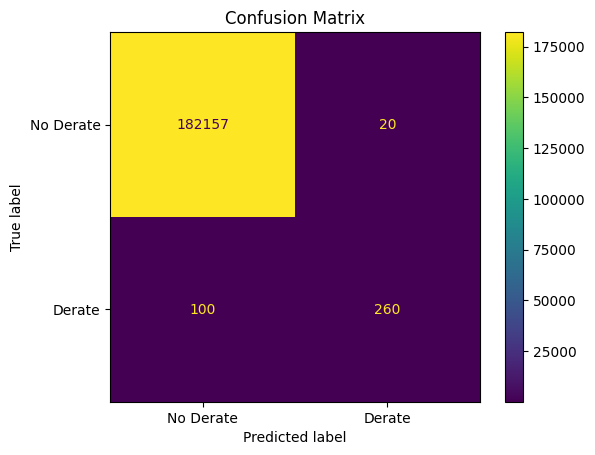

In [7]:

# Evaluate using YDF's built-in evaluation (optional but provides detailed report)
evaluation = model.evaluate(test_df)
print("Full evaluation report: ", evaluation)

# Evaluate using sklearn's f1_score
print("Calculating macro F1 score...")
macro_f1 = f1_score(y_test, y_pred_class, average="macro")
print(f"Macro F1 Score: {macro_f1:.4f}")

# Optional: Print classification report and confusion matrix for more detail
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

print("\nConfusion Matrix: (see image)\n")
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Derate", "Derate"]
)
disp.plot()
plt.title("Confusion Matrix")

cm = pd.DataFrame(cm)
TN = cm.iloc[0, 0].astype(int)
FP = cm.iloc[0, 1].astype(int)
FN = cm.iloc[1, 0].astype(int)
TP = cm.iloc[1, 1].astype(int)
Costs = FP * 500
Savings = TP * 4000
Net = Savings - Costs
print(f"\nNet savings: ${Net}")

# show confusion matrix plot
plt.show()
